In [1]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
rng = np.random.default_rng()

In [2]:
N_Aiv, N_HVC = 500, 9
c = 1
w0_mean, w0_std = 0.5, 0.2

In [3]:
net = HVC_Aiv(N_Aiv, N_HVC, c, w0_mean, w0_std)

In [4]:
peak_rate, kernel_width = 50, 2.5

In [5]:
T_rend = 300 # Each rendition
N_rend = 20 # Number of renditions
T = N_rend * T_rend # Total

In [6]:
# Syllables and time stamps
syl = rng.normal(0, 1, size=(N_HVC, N_Aiv))
tsyl_start = np.array([[T_rend * (j + i/(N_HVC+1)) for j in range(N_rend)]
                       for i in range(N_HVC)])
tsyl_end = tsyl_start + T_rend * 1/(N_HVC+1)
burst_ts = tsyl_start + T_rend * 0.5/(N_HVC+1)

In [7]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
HVC_rates = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [8]:
aud = generate_discrete_aud(T, N_Aiv, tsyl_start.T.flatten(), tsyl_end.T.flatten(), 
                            np.tile(syl, (N_rend, 1)), 0.1)

In [18]:
rmax, s, th = 50, 1, 2.5
phi = lambda x: rmax / (1 + np.exp(-s * (x - th)))

In [19]:
Aiv_rates = np.zeros((T, N_Aiv))
Aiv_rates[0] = phi(syl[0] + rng.normal(0, 0.01, size=N_Aiv))

dt = 5

for t in range(1, T):
    Aiv_rates[t] += (Aiv_rates[t] + phi(net.W @ HVC_rates[t-1] + aud[t-1])) / dt

In [20]:
def correlation(sig1, sig2, g): 
    ''' 
    sig1: (T, N)
    sig2: (P, N)
    g: Function
        Applied to sig2
    '''
    sig2 = g(sig2)
    sig1 = (sig1 - sig1.mean(axis=1, keepdims=True)) / sig1.std(axis=1, keepdims=True)
    sig2 = (sig2 - sig2.mean(axis=1, keepdims=True)) / sig2.std(axis=1, keepdims=True)
    corr = sig1 @ sig2.T / sig1.shape[1]
    assert np.nanmax(np.abs(corr)) < 1 + 1e-5
    return corr

In [21]:
corr = correlation(Aiv_rates, syl, lambda x: x)

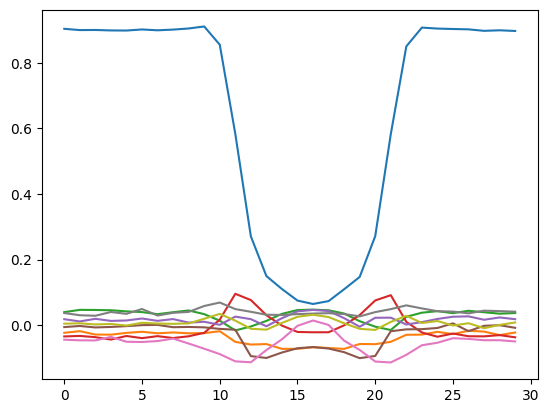

In [27]:
plt.plot(corr[:30]);